In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [2]:
# Load data
data_path = "E:\Folder tai lieu\Lectures\scalable\project2\Stock-Price-Forecasting-System-Using-Apache-Spark-main\data\processed\data.csv"
df = pd.read_csv(data_path)
df["Date"] = pd.to_datetime(df["Date"])
df = df.sort_values(by="Date")

# Feature selection
features = ["Open", "High", "Low", "Volume", "MA_10", "MA_50", "RSI", "Upper_BB", "Lower_BB", "Stoch_Osc"]
target = "Target"

# Splitting data
train_size = int(len(df) * 0.8)
train_data, test_data = df[:train_size], df[train_size:]
X_train, y_train = train_data[features], train_data[target]
X_test, y_test = test_data[features], test_data[target]


In [3]:
# Linear Regression Model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_predictions = lr_model.predict(X_test)
lr_rmse = np.sqrt(mean_squared_error(y_test, lr_predictions))
print(f"Linear Regression RMSE: {lr_rmse}")


Linear Regression RMSE: 13.849405271879018


In [4]:
# ARIMA Model
arima_model = ARIMA(train_data["Close"], order=(5,1,0))
arima_fit = arima_model.fit()
arima_predictions = arima_fit.forecast(steps=len(y_test))
arima_rmse = np.sqrt(mean_squared_error(y_test.values, arima_predictions.values[:len(y_test)]))
print(f"ARIMA RMSE: {arima_rmse}")


ARIMA RMSE: 70.50919845951786


In [5]:
# LSTM Model
scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(train_data[["Close"]])
scaled_test = scaler.transform(test_data[["Close"]])

def create_sequences(data, time_steps=10):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i : i + time_steps])
        y.append(data[i + time_steps])
    return np.array(X), np.array(y)

time_steps = 10
X_train_lstm, y_train_lstm = create_sequences(scaled_train, time_steps)
X_test_lstm, y_test_lstm = create_sequences(scaled_test, time_steps)

lstm_model = Sequential([
    Input(shape=(time_steps, 1)),
    LSTM(50, activation="relu", return_sequences=True),
    Dropout(0.2),
    LSTM(50, activation="relu"),
    Dropout(0.2),
    Dense(1)
])
lstm_model.compile(optimizer="adam", loss="mse")
lstm_model.fit(X_train_lstm, y_train_lstm, epochs=20, batch_size=16, verbose=0)
lstm_predictions = lstm_model.predict(X_test_lstm)
lstm_predictions = scaler.inverse_transform(lstm_predictions)
y_test_lstm = scaler.inverse_transform(y_test_lstm.reshape(-1, 1))
lstm_rmse = np.sqrt(mean_squared_error(y_test_lstm, lstm_predictions))
print(f"LSTM RMSE: {lstm_rmse}")


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step  
LSTM RMSE: 24.25585760884128


In [6]:
# Hybrid Model (Averaging Predictions)
min_length = min(len(lr_predictions), len(arima_predictions), len(lstm_predictions))
hybrid_predictions = (lr_predictions[:min_length] + arima_predictions[:min_length] + lstm_predictions.flatten()[:min_length]) / 3
hybrid_rmse = np.sqrt(mean_squared_error(y_test_lstm[:min_length], hybrid_predictions))
print(f"Hybrid Model RMSE: {hybrid_rmse}")


Hybrid Model RMSE: 39.092612628001135


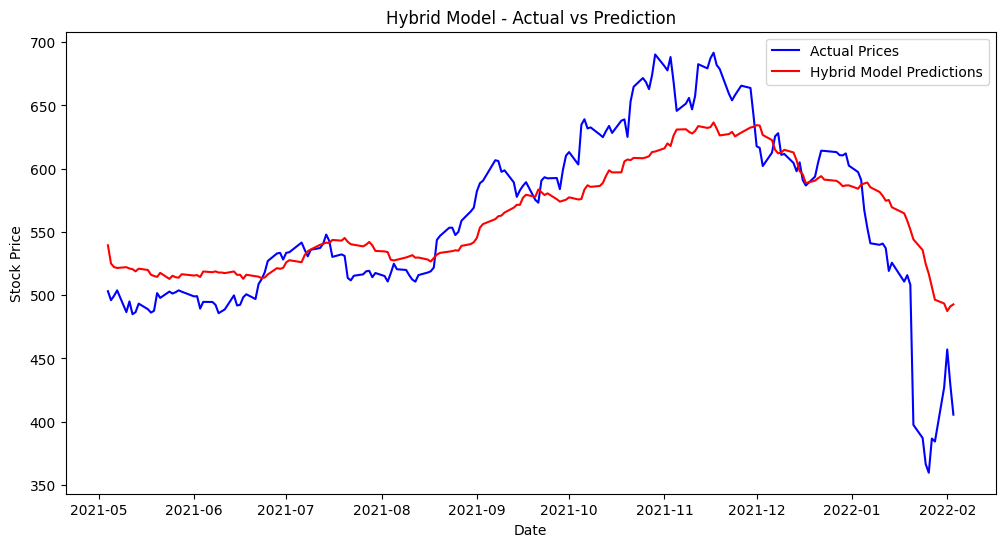

In [7]:
# Visualization
plt.figure(figsize=(12, 6))
plt.plot(df["Date"][train_size + time_steps:train_size + time_steps + min_length], y_test_lstm[:min_length], label="Actual Prices", color='blue')
plt.plot(df["Date"][train_size + time_steps:train_size + time_steps + min_length], hybrid_predictions, label="Hybrid Model Predictions", color='red')
plt.legend()
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.title("Hybrid Model - Actual vs Prediction")
plt.show()


In [8]:
# Backtesting (Calculate errors and performance over different time periods)
print(f"Linear Regression RMSE: {lr_rmse}")
print(f"ARIMA RMSE: {arima_rmse}")
print(f"LSTM RMSE: {lstm_rmse}")
print(f"Hybrid Model RMSE: {hybrid_rmse}")


Linear Regression RMSE: 13.849405271879018
ARIMA RMSE: 70.50919845951786
LSTM RMSE: 24.25585760884128
Hybrid Model RMSE: 39.092612628001135
